# Tag Evolution

In [4]:
import seaborn as sns
import matplotlib.pyplot  as plt
import pandas as pd
import numpy as np
from datetime import datetime

%matplotlib inline

In [2]:
from src.maps import tag_map

def extract_days_to_resolution(review: dict):
    if "datetime" in review and "reply" in review["responses"]["final"]:
        init_dt = datetime.strptime(review["datetime"], '%Y-%m-%dT%H:%M:%SZ')
        final_ans_dt = datetime.strptime(review["responses"]["final"]["reply"][0]["datetime"], '%Y-%m-%dT%H:%M:%SZ')
        days_diff = (final_ans_dt - init_dt).days
        if days_diff < 0:
            return 0
        return days_diff
    return np.nan


def extract_days_to_first_contact(review: dict):
    if "datetime" in review and "business" in review["responses"] and len(review["responses"]["business"]) > 0:
        init_dt = datetime.strptime(review["datetime"], '%Y-%m-%dT%H:%M:%SZ')
        final_ans_dt = datetime.strptime(review["responses"]["business"][0]["datetime"], '%Y-%m-%dT%H:%M:%SZ')
        days_diff = (final_ans_dt - init_dt).days
        if days_diff < 0:
            return 0
        return days_diff
    return np.nan


def extract_seals(review: dict):
    """
    Extract seals from review dict
    :param review:
    :return:
    """
    hasSeal = lambda r: "responses" in r and "final" in r["responses"] and "seals" in r["responses"]["final"] and len(
        r["responses"]["final"]["seals"]) > 0
    seal_struct = {"service_grade": np.nan, "would_buy_again": np.nan}

    if hasSeal(review):
        for seal in review["responses"]["final"]["seals"]:
            if seal["seal"] == "Nota do atendimento":
                seal_struct["service_grade"] = int(seal["value"])
            elif seal["seal"] == "Voltaria a fazer negócio?":
                seal_struct["would_buy_again"] = False if seal["value"] == "Não" else True

    return seal_struct


def format_RA_to_df(review):
    """
    Format scrapped review dict into a pandas friendly data structure
    :param review:
    :return:
    """
    cols_for_df = ['title', 'description', 'business_name', 'uf', 'city', 'review_ID', 'datetime', 'timeCaptured']
    r_cp = {col: review[col] for col in cols_for_df if col in review}

    r_cp["days_to_resolution"] = extract_days_to_resolution(review)
    r_cp["days_to_first_contact"] = extract_days_to_first_contact(review)
    r_cp["resolution_outcome"] = review["responses"]["final"]["result"] if "responses" in review and "final" in review[
        "responses"] and "result" in review["responses"]["final"] else np.nan

    # Extract seals and add to dict
    seals = extract_seals(review)
    for seal_name, seal_value in seals.items():
        r_cp[seal_name] = seal_value

    # Add macro-tags
    macro_tags = tag_map.keys()
    for t in macro_tags:
        if isinstance(tag_map[t], dict):
            for sub_t in tag_map[t].keys():
                r_cp[f"{t}_{sub_t}"] = np.nan
        else:
            r_cp[t] = np.nan

    # Count macro tags for complaint
    if "tags" in review:
        for tag in review["tags"]:
            
            for macro, vals in tag_map.items():
                if isinstance(tag_map[macro], dict):
                    
                    for sub_t in tag_map[macro].keys():
                        
                        tag_name = f"{macro}_{sub_t}"
                        
                        if tag in tag_map[macro][sub_t]:
                            if isinstance(r_cp[tag_name], type(np.nan)):
                                r_cp[tag_name] = 1
                            else:
                                r_cp[tag_name] += 1
                else:
                    # Others type -> list
                    if tag in vals:
                        if isinstance(r_cp[macro], type(np.nan)):
                            r_cp[macro] = 1
                        else:
                            r_cp[macro] += 1

    # Add MACRO-macro-tags
    macro_tags_2 = tag_map.keys()
    for t in macro_tags_2:
        r_cp[t] = np.nan

    # Count MACRO macro tags for complaint
    if "tags" in review:
        for tag in review["tags"]:
            for macro, vals in tag_map.items():
                if isinstance(tag_map[macro], dict):
                    for sub_t in tag_map[macro].keys():
                        tag_name = f"{macro}"
                        if tag in tag_map[macro][sub_t]:
                            if isinstance(r_cp[tag_name], type(np.nan)):
                                r_cp[tag_name] = 1
                            else:
                                r_cp[tag_name] += 1
                else:
                    # Others type -> list
                    if tag in vals:
                        if isinstance(r_cp[macro], type(np.nan)):
                            r_cp[macro] = 1
                        else:
                            r_cp[macro] += 1
    return r_cp


def build_df_from_RA(reviews: list) -> pd.DataFrame:
    return pd.DataFrame([format_RA_to_df(r) for r in reviews])

In [7]:
from src.loading import load_dataset
#from cleaning import build_df_from_RA

reviewsRA = load_dataset("final_dataset_RA")
df = build_df_from_RA(reviewsRA)
print(f"We have a total of {len(reviewsRA)} reviews!")

We have a total of 51655 reviews!


In [8]:
df.columns

Index(['business_issues', 'business_issues_Customer Services',
       'business_issues_Delivery', 'business_issues_Maintenance',
       'business_issues_Online Services', 'business_issues_Payment',
       'business_name', 'city', 'datetime', 'days_to_first_contact',
       'days_to_resolution', 'description', 'others', 'product_issues',
       'product_issues_Damaged', 'product_issues_Electrical problems',
       'product_issues_Missing pieces', 'product_issues_Quality', 'products',
       'products_Accessories', 'products_Decoration', 'products_Eletronics',
       'products_Furniture', 'products_Home Appliances', 'products_Others',
       'resolution_outcome', 'review_ID', 'service_grade', 'timeCaptured',
       'title', 'uf', 'would_buy_again'],
      dtype='object')

In [9]:
df['datetime'] = pd.to_datetime(df.datetime)
df['month'] = df['datetime'].dt.strftime('%m/%Y')

In [10]:
agg = df.groupby(['business_name','month']).agg({'business_issues':['sum', 'count'],
                                                      'product_issues':['sum', 'count'],
                                                      'datetime':'max'})

In [11]:
df_agg = pd.DataFrame(agg.to_records())
df_agg.columns = ['business_name','date','business_issues', 'business_issues_count', 
                    'product_issues', 'product_issues_count','datetime'] 

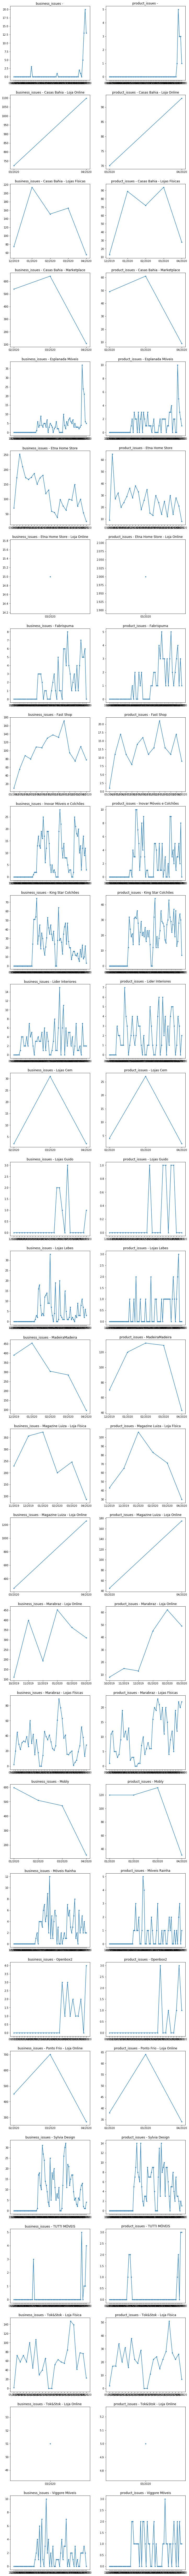

In [12]:
fig = plt.figure(figsize=(12,180))
w=1
for j in df_agg['business_name'].unique():
    for i in ['business_issues', 'product_issues']:
        plt.subplot(29,2,w)
        plt.plot('date', i,data=df_agg[df_agg['business_name']==j].sort_values(by='datetime'),
                 marker='.')
        plt.title(i+' - '+j);
        w=w+1